Loading CIFAR-100 dataset...
Training set loaded successfully.
Test set loaded successfully.
Starting training...
Epoch [1/5], Loss: 3.5571
Epoch [2/5], Loss: 2.8169
Epoch [3/5], Loss: 2.4801
Epoch [4/5], Loss: 2.2314
Epoch [5/5], Loss: 2.0546
Training completed.
Test Accuracy: 39.96%
Confusion Matrix:
[[77  1  0 ...  0  1  1]
 [ 0 47  0 ...  0  0  0]
 [ 4  0 18 ...  0  4  1]
 ...
 [ 0  0  0 ... 37  1  0]
 [ 2  0  3 ...  1 10  2]
 [ 0  0  0 ...  0  0 29]]
Flattening images for PCA...
Computing PCA components...
PCA stopped at 87 components retaining 90% variance.


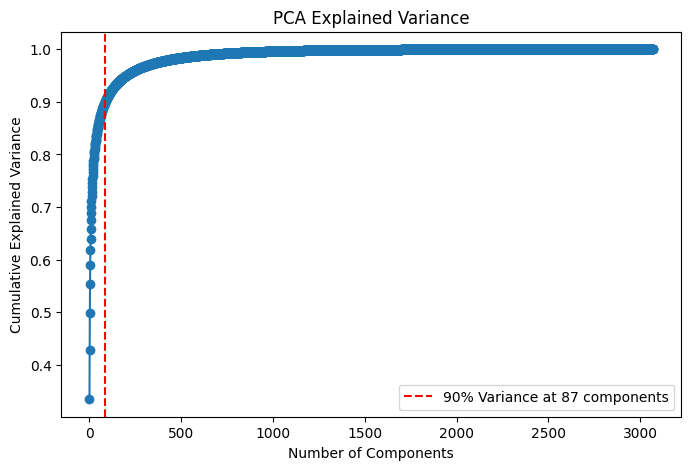

Applying K-Means Clustering...
K-Means clustering completed.


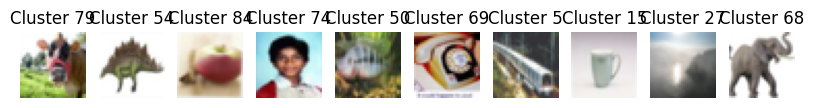

Visualization completed.
CIFAR-100 is a dataset which contains 60,000 total images, which are split between 50,000 training images and 10,000 test images
Each image is in color and has a size of 32x32 pixels
CIFAR-100 contains 100 unique classes, further categorized into 20 superclasses, for images to be classified into
CIFAR-100 was created by the Canadian Institute for Advanced Research for the purpose of training AI models on image classification


In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Load CIFAR-100 Dataset (Changed from CIFAR-10 to CIFAR-100)
print("Loading CIFAR-100 dataset...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)  # Changed to CIFAR-100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
print("Training set loaded successfully.")

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)  # Changed to CIFAR-100
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
print("Test set loaded successfully.")

#######################################
# Step 1: Define CNN Model
#######################################
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 100)  # Changed output size from 10 to 100 for CIFAR-100

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize CNN model
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#######################################
# Step 2: Train the CNN Model
#######################################
epochs = 5
print("Starting training...")
for epoch in range(epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}")

print("Training completed.")

#######################################
# Step 3: Evaluate the Model
#######################################
correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Confusion Matrix (Adjusted for 100 classes)
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

#######################################
# Step 4: Apply PCA for Dimensionality Reduction
#######################################
print("Flattening images for PCA...")
X_train_flat = np.array([image.numpy().flatten() for image, _ in trainset])  # Adjusted for CIFAR-100 images

print("Computing PCA components...")
pca = PCA()
X_pca_full = pca.fit_transform(X_train_flat)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.90) + 1  # Keeping 90% variance
X_pca = X_pca_full[:, :n_components]
print(f"PCA stopped at {n_components} components retaining 90% variance.")

# Plot Cumulative Variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.axvline(n_components, color='r', linestyle='--', label=f'90% Variance at {n_components} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.title('PCA Explained Variance')
plt.show()

#######################################
# Step 5: Apply K-Means Clustering
#######################################
print("Applying K-Means Clustering...")
kmeans = KMeans(n_clusters=100, random_state=42, n_init=10)  # Updated to 100 clusters for CIFAR-100
kmeans.fit(X_pca)
clusters = kmeans.labels_
print("K-Means clustering completed.")

#######################################
# Step 6: Visualize Clustered Images
#######################################
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axes[i].imshow(trainset.data[i])  # Using CIFAR-100 dataset images
    axes[i].set_title(f"Cluster {clusters[i]}")
    axes[i].axis('off')
plt.show()
print("Visualization completed.")

#######################################
# Step 7: Insights
#######################################
print("CIFAR-100 is a dataset which contains 60,000 total images, which are split between 50,000 training images and 10,000 test images")
print("Each image is in color and has a size of 32x32 pixels")
print("CIFAR-100 contains 100 unique classes, further categorized into 20 superclasses, for images to be classified into")
print("CIFAR-100 was created by the Canadian Institute for Advanced Research for the purpose of training AI models on image classification")

